In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Grover's Algorithm
$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$


---

## Overview

This notebook provides an introduction to Grover's algorithm, a landmark quantum algorithm that has the potential to enable efficient search of unsorted databases. There are several expositions of Grover's algorithm online including [this video by 3Blue1Brown](https://www.3blue1brown.com/lessons/grover), [section 5.8 of Girvin's class notes](https://girvin.sites.yale.edu/sites/default/files/files/_Girvin_Introduction_to_Quantum_2024_04_21_v45.pdf), and [section 7.6 of Thomas Wong's book](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf).  By learning Grover's algorithm, you will recognize patterns and structure that are also used in other quantum algorithms, such as:

- [Deutsch-Jozsa algorithm](https://nvidia.github.io/cuda-quantum/latest/applications/python/deutsch_jozsa.html) (distinguishing constant from balanced functions)
- Simon’s algorithm (finding hidden periodicity)
- [Shor’s algorithm](https://nvidia.github.io/cuda-quantum/latest/applications/python/shors.html) (factoring via [quantum Fourier transform](https://nvidia.github.io/cuda-quantum/latest/applications/python/quantum_fourier_transform.html)).



By the end of this notebook you will be able to

- understand the theoretical foundations of Grover's algorithm
- apply the algorithm to solve specific search problems
- design and implement your own simulations of Grover's algorithm using CUDA-Q

Before we get started, we will need to import a few libraries:


In [1]:
# Uncomment out if cudaq isn't installed
#%pip install cudaq

In [59]:
import cudaq
import matplotlib.pyplot as plt
import numpy as np
import itertools

---

## Problem

We consider the problem of locating one or more marked items in an unstructured database, where no prior information about the structure of the data is available. We can make this explicit by considering a database made up of binary strings of length $n$. Let $\mathbb{B}^n$ denote the set of binary strings of length $n$ and
$$f: \mathbb{B}^n
\to \{0,1\}$$
be a Boolean function that encodes the marked elements, i.e. $f(x) =1$ if and only if $x$ is a marked string. Our goal is to find all strings $x$ such that $f(x) = 1$.

Classically, if we have no prior knowledge about $f$ (i.e., it is given as a black-box oracle), the best strategy requires $O(N)$ evaluations, where $N = 2^n$ is the total number of binary strings. However, there exists a quantum algorithm due to L. Grover that finds a solution using only $O(\sqrt{N})$ oracle queries  ([Grover, 1996](https://arxiv.org/abs/quant-ph/9605043)).  

We will use computational basis states on $n$ qubits to represent the $2^n$ elements in the database $B^n$.  Our goal is to create a quantum kernel that separates the marked states from the non-marked states. That is, sampling from the kernel yields a marked state with high probability and a non-marked state with low probability.  

An alternative approach to this problem involves discrete time quantum walks.  For an introduction to discrete time quantum walks refer to the [CUDA-Q Academic notebook](https://github.com/NVIDIA/cuda-q-academic/blob/main/quick-start-to-quantum/03_quick_start_to_quantum.ipynb) and for details of using discrete time quantum walks for the search problem, consult [Thomas Wong's exposition](https://arxiv.org/pdf/2011.14533).


---

## Step\-by\-Step Example: Understanding Grover's Algorithm

In this notebook, we use a concrete example to illustrate the key steps and concepts behind Grover’s algorithm. Each section begins with an explanation of the theoretical foundations of a specific stage of the algorithm, followed by a step-by-step walkthrough applying these ideas to our example.

Let $n=4$ and mark the states `1001` and `1111`.  The code block below defines the Boolean function, which we'll call `marking_function` that encodes the marked elements.



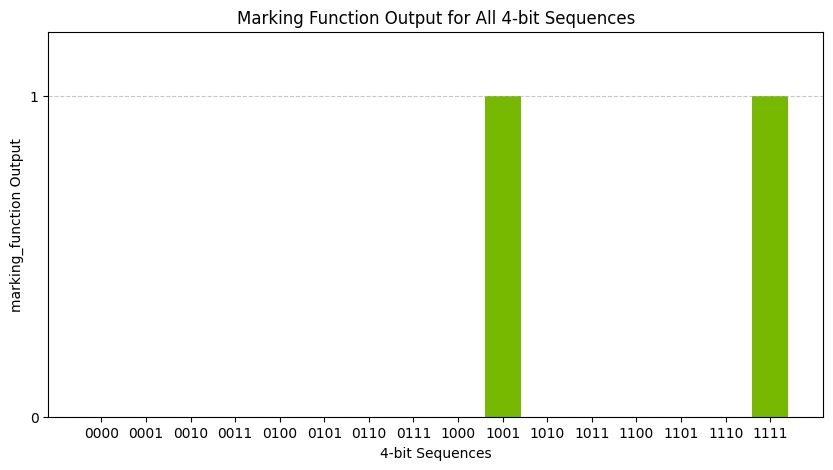

In [60]:
# Define a Boolean function that encodes the marked elements `1001` or `1111`
marked_elements_list = ['1001', '1111']

def marking_function(bit_string):
    if bit_string in marked_elements_list:
        return 1
    else:
        return 0

# Print out some example function calls to verify that the marking_function works as required

bit_strings = [''.join(bits) for bits in itertools.product('01', repeat=4)]

# Compute the function outputs for each bit string
outputs = [marking_function(bs) for bs in bit_strings]

# Create a bar graph
plt.figure(figsize=(10, 5))
plt.bar(bit_strings, outputs, color='#76B900', edgecolor='none')

plt.xlabel('4-bit Sequences')
plt.ylabel('marking_function Output')
plt.title('Marking Function Output for All 4-bit Sequences')
plt.ylim(0, 1.2)  # Provides some padding above the bar height
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Set y-axis to only show 0 and 1 as tickmarks
plt.yticks([0, 1])
plt.show()


---

## Structure of Grover's Algorithm

Grover's Algorithm can be broken down into the following steps:

1. Preparation: Initialize $n$ qubits in an equal superposition state.  
2. Oracle Application: Apply the oracle operator to flip the phase of the marked states (i.e., multiply them by $-1$).
3. Amplitude Amplification: Use the diffusion operator to amplify the amplitudes of the marked states.
4. Iteration: Repeat Steps 2 and 3 a specified number of times, which depends on the number of marked elements and $n$.
5. Measurement: Measure the qubits. With high probability, the result will be one of the marked states.

These steps are implicit in the circuit diagram below, which we'll describe in more detail in the following sections.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main/qis-examples/images/grovers-circuit.png?raw=true)

Between the sections describing Step 1 and Step 2, we will introduce two quantum states (the good and the bad state) and their geometric interpretation that will help motivate Steps 3 and 4.


### Step 1: Preparation
The first step of Grover's algorithm requires initializing $n$ qubits in a state of equal superposition:

$$
\ket{\xi}:= H^{\otimes n} (|0\rangle^{\otimes n}) = \frac{1}{\sqrt{N}} \sum\limits_{i=0}^{N-1} |i\rangle,
$$
where each binary string is identified with the integer it represents (e.g., $|5\rangle = |0101\rangle$).

The kernel in the code block below places the $n$ qubits in an equal superposition state.


In [61]:
# Kernel to create an equal superposition state of qubits initialized to |0>
@cudaq.kernel
def equal_superposition(qubits_in_zero_state : cudaq.qview):
    h(qubits_in_zero_state)

To test that the `equal_superposition` function acts as required, let's create a quantum kernel and sample it. We will also use the `get_state` command to get the probability amplitudes of the state, which should all be $\frac{1}{2^4}=\frac{1}{16}$. The sampling block below uses `shots_count` parameter equal to $16000$, so we expect each of the $16$ basis states to appear approximately $\frac{1}{16} \cdot 16000 = 1000$ times in the histogram.  We'll also define helper functions to visualize the sampling results and to print out the statevector.

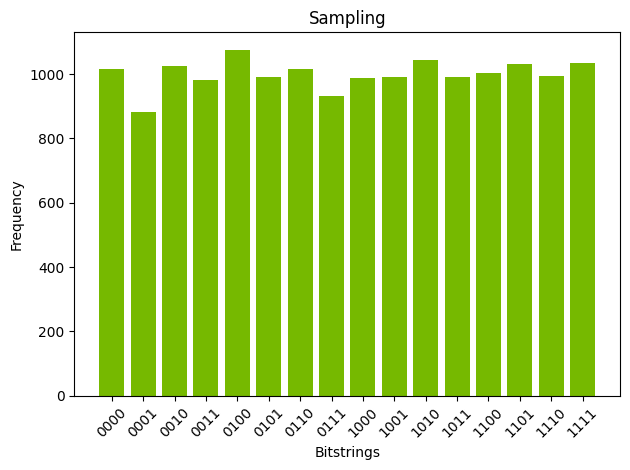

The statevector for the equal_superposition_state is:
 0.25|0000> + 0.25|0001> + 0.25|0010> + 0.25|0011> + 0.25|0100> + 0.25|0101> + 0.25|0110> + 0.25|0111> + 0.25|1000> + 0.25|1001> + 0.25|1010> + 0.25|1011> + 0.25|1100> + 0.25|1101> + 0.25|1110> + 0.25|1111> 


In [64]:
# Testing the equal_superposition function and defining a helper function for graphing states

# Set the number of qubits
num_qubits = 4

# Helper functions
# Define a function to draw the histogram of the results of sampling a kernel
def plot_results(result, num_qubits):
    # Define a dictionary of results

    # Initialize the dictionary with all possible bit strings of length 4 for the x axis
    result_dictionary = {}

    # Generate all possible bit strings of length num_qubits
    for i in range(2**num_qubits):
        bitstr = bin(i)[2:].zfill(num_qubits)
        result_dictionary[bitstr] = 0

    # Update the results dictionary of results from the circuit sampling
    for k,v in result.items():
        result_dictionary[k] = v

    # Convert the dictionary to lists for x and y values
    x = list(result_dictionary.keys())
    y = list(result_dictionary.values())

    # Create the histogram
    plt.bar(x, y, color='#76B900')

    # Add title and labels
    plt.title("Sampling")
    plt.xlabel("Bitstrings")
    plt.ylabel("Frequency")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Define a helper function to format the quantum state as a string representation
def format_quantum_state(bit_length, state):
    """
    Format a quantum state as a string representation.
    
    Parameters:
    bit_length (int): Length of the bit strings
    amplitudes (dict or list): Either a dictionary mapping bit strings to amplitudes,
                               or a list of amplitudes indexed by the integer value of the bit string
    
    Returns:
    str: String representation of the quantum state
    """
    # Generate all bit strings of the given length
    bit_strings = [''.join(bits) for bits in itertools.product('01', repeat=bit_length)]
    
    # Initialize the output string
    output = ""
    first_term = True
    # Iterate over all bit strings using index
    for idx in range(len(bit_strings)):
        bitstring = bit_strings[idx]
        
        # Get the amplitude based on the type of input
        amplitude = state.amplitude(bitstring) 
        
        # Check if amplitude is non-zero (using a small threshold for floating-point comparison)
        if abs(amplitude) > 1e-10:
            # Format the amplitude based on its components
            if abs(amplitude.imag) < 1e-10:  # Essentially real
                amp_str = f"{amplitude.real:.2f}"
            else:
                amp_str = f"{amplitude:.2f}"
            
            # Remove trailing zeros after decimal point for cleaner display
            amp_str = amp_str.replace('.00', '')
            if amp_str.endswith('.0j'):
                amp_str = amp_str.replace('.0j', 'j')
            if amp_str.startswith('(') and amp_str.endswith(')'):
                amp_str = amp_str[1:-1]
                
            # Add to output string with proper sign handling
            if first_term:
                output += f"{amp_str}|{bitstring}> "
                first_term = False
            else:
                # Check if the term starts with a negative sign
                if amp_str.startswith('-'):
                    output += f"{amp_str}|{bitstring}> "
                else:
                    output += f"+ {amp_str}|{bitstring}> "
    
    # If no terms were added, return zero state
    if not output:
        return "0"
    
    return output

# Define a kernel to test the equal_superposition function
@cudaq.kernel()
def test_kernel(num_qubits : int):
    # Initialize qubits in the zero state
    qubits = cudaq.qvector(num_qubits)

    # Place qubits in equal superposition
    equal_superposition(qubits)

# Sample the test_kernel
results = cudaq.sample(test_kernel, num_qubits, shots_count = 16000)

# Plot the histogram of sampling results
plot_results(results, num_qubits)

equal_superposition_state = cudaq.get_state(test_kernel, num_qubits)
print('The statevector for the equal_superposition_state is:\n', format_quantum_state(num_qubits, equal_superposition_state))

The histogram illustrates the distribution from sampling the state $|\xi\rangle$, showing that each bitstring has roughly equal probability of being measured. In this notebook, our objective is to implement Grover's Algorithm by developing a kernel that transforms the equal superposition state into one where the probability amplitudes of the marked states are amplified, making them more likely to be sampled than the other states.


### Good and Bad States: Explanation

We can simplify our analysis of Grover's Algorithm by focusing on two useful quantum states, which we'll refer to as the "good" and "bad" states.  The "good" state captures the marked bitstrings and the "bad" state is orthogonal to the "good" state.

Suppose there are $t$ marked states, i.e., there are $t$ elements $x \in \mathbb{B}^n$ with $f(x) = 1$. Letting $N=2^n$, we introduce the following quantum states:

$$
|G\rangle := \frac{1}{\sqrt{t}} \sum\limits_{i, f(i) = 1} |i\rangle, \quad |B\rangle := \frac{1}{\sqrt{N - t}} \sum\limits_{i, f(i) = 0} |i\rangle.
$$

These are the uniform superpositions of marked and unmarked states, referred to as the "good" and "bad" states, respectively.  

Rewriting the uniform superposition state $\ket{\xi}$ in terms of $|G\rangle$ and $|B\rangle$, we obtain:

$$
\ket{\xi} = \frac{1}{\sqrt{N}} \sum\limits_{i, f(i) = 1} |i\rangle + \frac{1}{\sqrt{N}} \sum\limits_{i, f(i) = 0} |i\rangle
= \frac{\sqrt{t}}{\sqrt{N}} |G\rangle + \frac{\sqrt{N - t}}{\sqrt{N}} |B\rangle.
$$



### Good and Bad States: Step-by-step Example

Let's see what this look likes for our example of $n=4$ and marked states `1001` and `1111`.  Here $\ket{\xi} = \frac{1}{16}\sum\limits_{k=0}^{15}\ket{k}$ since there are 4 qubits and 16 computational basis states with $\ket{0} = \ket{0000}, \ket{1} = \ket{0001}, \cdots, \ket{15} = \ket{1111}$.  The good state is an equal superposition of the states $\ket{9} =\ket{1001}$ and $\ket{15} =\ket{1111}$:
$$\ket{G} =  \frac{1}{\sqrt{2}}(\ket{9}+\ket{15} )= \frac{1}{\sqrt{2}}(\ket{1001}+\ket{1111}).$$

The bad state is an equal superposition of the remaining states:
$$\ket{B} = \frac{1}{\sqrt{14}}(\ket{0}+\ket{1}+\ket{2}+\cdots+\ket{8}+\ket{10}+\cdots+\ket{14}) = \frac{1}{\sqrt{14}}\sum_{x\in B^4}f(x)\ket{x}. $$

Notice that the states $\ket{G}$ and $\ket{B}$ are orthogonal (with respect to the standard Hermitian inner product on the Hilbert space $\mathcal{H} = (\mathbb{C}^2)^{\otimes n}$). We will verify this in the code block below by computing the 'overlap' between $\ket{G}$ and $\ket{B}$, which is equal to $|\langle G|{B}\rangle |$, the absolute value of the inner product of $\ket{G}$ and $\ket{B}$.



In [65]:
# Illustration of the orthogonality of the good and bad states

# Kernel for the good state

# Define a list of complex numbers
# for the coefficients of the state |good> = alpha|1001> + beta|1111>,
# where alpha = 1/sqrt(2)+0j and beta = -1/sqrt(2)+0j
good_coefficients = [complex(0, 0)] * 16
good_coefficients[9] = complex(np.sqrt(2)/2, 0)
good_coefficients[15] = complex(np.sqrt(2)/2, 0)

# Define a vector coefficients for the bad state
bad_coefficients = [complex(1/np.sqrt(14),0)]*16
bad_coefficients[9] = complex(0, 0)
bad_coefficients[15] = complex(0, 0)

# Define a cudaq.kernel to generate a state from a list of coefficients
@cudaq.kernel
def state_from_list(coefficients: list[complex]):
    q = cudaq.qvector(coefficients)


# Compute the overlap between the two states to verify it is 0.
good_state = cudaq.get_state(state_from_list, good_coefficients)
bad_state = cudaq.get_state(state_from_list, bad_coefficients)
overlap_good_bad = (good_state.overlap(bad_state)**2).real

print('The good state is', format_quantum_state(4, good_state),'\n')
print('The bad state is', format_quantum_state(4, bad_state),'\n')
print('Two states are orthogonal if the inner product between them is zero, or equivalently, if the overlap between them is zero. \n')
print('The overlap of the good and bad state is', overlap_good_bad)



The good state is 0.71|1001> + 0.71|1111>  

The bad state is 0.27|0000> + 0.27|0001> + 0.27|0010> + 0.27|0011> + 0.27|0100> + 0.27|0101> + 0.27|0110> + 0.27|0111> + 0.27|1000> + 0.27|1010> + 0.27|1011> + 0.27|1100> + 0.27|1101> + 0.27|1110>  

Two states are orthogonal if the inner product between them is zero, or equivalently, if the overlap between them is zero. 

The overlap of the good and bad state is 0.0


### Geometry of the Good and Bad States


In the standard basis, the vectors $|G\rangle$ and $|B\rangle$ have components consisting only of zeros and ones in complementary positions. Specifically, we can write:

$$
|G\rangle = \frac{1}{\sqrt{t}} (a_0, a_1, \dots, a_{N-1}) \text{ and }
|B\rangle = \frac{1}{\sqrt{N - t}} (\bar{a}_0, \bar{a}_1, \dots, \bar{a}_{N-1}),
$$

where $a_i \in \{0,1\}$ and $\bar{a}_i = 1 - a_i$. As we saw in the previous example, this structure ensures that $|G\rangle$ and $|B\rangle$ are orthogonal with respect to the standard Hermitian inner product:

$$
\langle G | B \rangle = 0.
$$




Next, let's introduce the angle $\theta$ between the equal superposition state $\ket{\xi}$ and the bad state $\ket{B}$.  We can compute this angle using the dot product formula. To compute the dot product of $\ket{\xi}$ with $\ket{B}$, notice that the coefficients for $\ket{\xi}$ are all $\frac{1}{\sqrt{N}}$ while the coefficients for $\ket{B}$ are all $\frac{1}{\sqrt{N-t}}$ except for the $t$ bad states that have coefficients $0$.  Furthermore, the states both have magnitude 1.  Therefore

$$\cos{\theta} = \frac{\ket{\xi}\cdot\ket{B}}{|\ket{\xi}||\ket{B}||} = \ket{\xi}\cdot\ket{B} = \frac{N-t}{\sqrt{N(N-t)}}$$



With this notation, we can rewrite $\ket{\xi}$ as:

$$
\ket{\xi} = \sin(\theta) |G\rangle + \cos(\theta) |B\rangle.
$$

Furthermore note that a similar calculation using the dot product of $\ket{G}$ and $\ket{\xi}$ can be conducted to derive that $\cos{(90^\circ-\theta)} = \frac{\sqrt{t}}{\sqrt{N}}$. This would imply that $\theta$ can also be written as 
$$\theta = \arcsin{\left(\frac{\sqrt{t}}{\sqrt{N}}\right)}.$$  

We'll use this fact later.


#### Geometry of the Good and Bad States: a Step-by-step Example
In the code block below, we verify that the equality, $
\ket{\xi} = \sin(\theta) |G\rangle + \cos(\theta) |B\rangle
$,  holds for our particular example. Recall that in our example, we have 2 marked states and 4 qubits, in other words $t =2$ and $ N = 2^4 = 16$.
In this case,  $\theta = \arccos(\frac{14}{\sqrt{16*14}})  \approx 21^\circ$.  To verify that $
\ket{\xi} = \sin(\theta) |G\rangle + \cos(\theta) |B\rangle
$, we will compute the inner product (using the overlap function) of  $
\ket{\xi} $ and  $\sin(\theta) |G\rangle + \cos(\theta) |B\rangle$, which we expect to be close to 1.

In [66]:
# First we create the state sin(theta)|G> + cos(theta)|B>
# by making a list of complex coefficients

# Set the angle theta
theta = np.arccos(14/np.sqrt(14*16))

coefficients = [np.sin(theta)*good_coefficients[i] + np.cos(theta)*bad_coefficients[i] for i in range(len(good_coefficients))]
lin_combination_state =  cudaq.get_state(state_from_list, coefficients)

# Then we compute the overlap between this state and the uniform supersposition state
overlap = (equal_superposition_state.overlap(lin_combination_state)**2).real

print('The overlap between the two states should be close to 1.')
print('The computed overlap is ',overlap)

The overlap between the two states should be close to 1.
The computed overlap is  0.9999999999999998


Let us now examine the geometric picture behind our current discussion. We'll consider the ambient Hilbert space to be spanned by the standard basis vectors $|0\rangle, |1\rangle, \dots, |N-1\rangle$, where the full dimension is $N = 2^n$. Since the uniform superposition state $|\xi\rangle$ can be expressed as a linear combination of the states $|G\rangle$ and $|B\rangle$ with real coefficients, all three states $|\xi\rangle, |G\rangle,$ and $|B\rangle$ reside in a two-dimensional real subspace of the ambient Hilbert space, which we can visualize as a 2D plane as in the image below.  Since, $|G\rangle$ and $|B\rangle$ are orthogonal, we can imagine them graphed as unit vectors in the positive $y$ and positive $x$ directions, respectively.  From our previous expression, $\ket{\xi} = \sin(\theta) |G\rangle + \cos(\theta) |B\rangle,$ we see that the state $|\xi\rangle$ forms an angle $\theta$ with $|B\rangle$.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main//qis-examples/images/grovers-2D-plane.png?raw=true?)

Given that the number of marked states $t$ is typically small compared to $N$, it follows that $\theta$ is a small angle. This assumption is reasonable, as otherwise, a sufficient number of independent queries to the oracle would likely yield a solution through classical search methods.


### Step 2: Oracle application



#### Step 2: Explanation


After we have created a state of equal superposition, the good state is marked by flipping its phase.  This is done with a **phase oracle**.  A phase oracle $U$ is a unitary operation that has the property that for a computational basis state $\ket{x}$

$$
U |x\rangle = 
\begin{cases} 
-|x\rangle & \text{if } |x\rangle \text{ is marked} \\
|x\rangle & \text{if } |x\rangle \text{ is not marked}
\end{cases}
$$

#### Step 2: Step-by-step example
Let's consider our example of the two marked states $\ket{9} =\ket{1001}$ and $\ket{15} =\ket{1111}$.  We'll first write a unitary matrix $U_{15}$ that flips the computational basis state $\ket{15}$ but keeps all other computational basis states fixed.  We work through this marked state first because we have a built-in gate that carries out the required action, and we'll see how we can adapt it to mark other marked states.  In particular, the multi-controlled Z gate applies a phase flip (-1) when all control qubits are in state |1⟩, and does nothing otherwise.  Let's see this in action:

In [67]:
# Define U_15 so that U_15|1111> = -|1111> but fixes 
# all other computational basis states |x>

# Set the number of qubits for the computational basis states
num_qubits = 4


# Using phase kickback, apply a multi-controlled Z gate
# with the auxiliary qubit as the target and all other qubits
# as the control
@cudaq.kernel
def U15(qubits: cudaq.qvector):
    z.ctrl(qubits.front(len(qubits) - 1), qubits.back())

# Create a kernel to test our defintion of U15
@cudaq.kernel
def flip_phase_of_15_only(num_qubits : int):
    qubits = cudaq.qvector(num_qubits)
 
    # Initialize the the qubits in a state of equal superposition
    equal_superposition(qubits)

    # Apply the U15 kernel
    U15(qubits)


# Get the state of the flip_phase_of_15_only kernel
result_get_state = cudaq.get_state(flip_phase_of_15_only, num_qubits)
print(format_quantum_state(4, result_get_state))


0.25|0000> + 0.25|0001> + 0.25|0010> + 0.25|0011> + 0.25|0100> + 0.25|0101> + 0.25|0110> + 0.25|0111> + 0.25|1000> + 0.25|1001> + 0.25|1010> + 0.25|1011> + 0.25|1100> + 0.25|1101> + 0.25|1110> -0.25|1111> 


Notice that the only state with a negative phase is the `1111` state.

Your exercise is to adapt the $U15$ oracle and create a new phase oracle $U_9$ which will flip the phase of the auxiliary qubit when the first four qubits are in the computational basis state $\ket{9} = \ket{1001}$ and doing nothing to the auxiliary qubit otherwise.  
Hint: consider creating a kernel that when applied to the state $\ket{1001}$ would carry out the sequence of transformations $\ket{1001}\rightarrow\ket{1111}\rightarrow-\ket{1111}\rightarrow-\ket{1001}$.

In [68]:
# SOLUTION
# Define U_9 so that U_9|1001> = -|1001> but fixes 
# all other computational basis states |x>

# Set the number of qubits for the computational basis states
num_qubits = 4

@cudaq.kernel
def U9(qubits: cudaq.qvector):

    x(qubits[1])
    x(qubits[2])
    z.ctrl(qubits.front(len(qubits) - 1), qubits.back())
    x(qubits[1])
    x(qubits[2])

# Create a kernel to test our defintion of U9
@cudaq.kernel
def flip_phase_for_9_only(num_qubits : int):
    qubits = cudaq.qvector(num_qubits)

    # Initialize the the qubits in a state of equal superposition
    equal_superposition(qubits)

    # Apply the U9 kernel
    U9(qubits)

# Get the state of the flip_phase_for_9_only kernel
result_U9 = cudaq.get_state(flip_phase_for_9_only,num_qubits)

print(format_quantum_state(4, result_U9))

0.25|0000> + 0.25|0001> + 0.25|0010> + 0.25|0011> + 0.25|0100> + 0.25|0101> + 0.25|0110> + 0.25|0111> + 0.25|1000> -0.25|1001> + 0.25|1010> + 0.25|1011> + 0.25|1100> + 0.25|1101> + 0.25|1110> + 0.25|1111> 


When you finish the exercise above, check that the only computational basis state after an application of `U9` with a negative phase is `1001`.  If so, how would you combine `U15` and `U9` to create an oracle that only flips the phase of `1111` and `1001` leaving all other computational basis states fixed?

In [69]:
# Define a phase oracle that flips the phases of |1001> and |1111>
# and fixes all other computational basis states |x>
@cudaq.kernel
def phase_oracle(qubits: cudaq.qvector):
    U9(qubits)
    U15(qubits)


### Step 3: Amplitude amplification



#### Step 3: Explanation

The main idea behind Grover's algorithm is to construct an operator (Grover iteration) that performs a clockwise rotation by $2\theta$ in the two-dimensional plane spanned by the state vectors $|G\rangle$ and $|B\rangle$. This is carried out through a composition of two rotations.  First $|\xi\rangle$ is reflected over $|B\rangle$ (by a rotation operation $r_B$) and then this state is reflected over $|\xi\rangle$ by a rotation operation $r_\xi$, as depicted in the animation below.

![](https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/refs/heads/main/images/grovers.gif)

After applying this operator $m = \lfloor \frac{\pi}{4\theta} \rfloor$ times, the state vector $|\xi\rangle$ becomes very close to $|G\rangle$. Consequently, performing a measurement in the standard basis yields one of the solutions with high probability.


The following section describes the derivation of the rotation gates $r_B$ and $r_\xi$ in general.  If you are not concerned with understanding the mathematics, you can skip this optional section and continue down to the section titled "Reflecting over the $\ket{0000}$ State: Step-by-step example" to see how this operation is defined for our particular $4$-qubit example.

#### \(optional\) Realizing Grover's Diffusion Operator: Reflection as Composition of Rotations



In this section we will derive the gate sequences needed to carry out the rotations $r_B$ followed by $r_\xi$.  We'll start by examining rotations in general.

Let $v \in \mathbb{R}^N$ be a vector, and let $r_v$ denote the reflection with respect to $v$. By reflection $r_v$ with respect to a vector, we mean the linear map that leaves $v$ unchanged and maps any vector orthogonal to $v$ to its negative:

$$
r_v(v) = v \quad \text{and} \quad r_v(w) = -w \quad \text{for} \quad w \text{ such that } (v, w) = 0,
$$

where $(\bullet, \bullet)$ denotes the dot product on $\mathbb{R}^N$.

If $v$ and $w$ are two vectors, then the composition of reflections with respect to them results in a rotation by twice the angle between them in the two-dimensional plane they span:

$$
r_w \circ r_v = \text{rotation by } 2\theta \text{ from } v \text{ to } w,
$$

where $\theta = \arccos\left(\frac{(v, w)}{|v||w|}\right)$ is the angle between $v$ and $w$.

In the case where $v$ and $w$ are unit vectors, i.e., $|v| = |w| = 1$, this formula simplifies to $\theta = \arccos((v, w))$.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main//qis-examples/images/rotation.png?raw=true?)




In order to realize Grover's iteration operator, which performs a rotation by $2\theta$ in the direction from $|B\rangle$ to $|G\rangle$, we will construct the reflections with respect to the state vectors $|B\rangle$ and $|\xi\rangle$. We will denote this operator by

$$
\mathcal{G} := r_\xi \circ r_{B}.
$$

First, we focus on the reflection with respect to $|B\rangle$. The oracle for our Boolean function $f$ is the unitary operator $\mathcal{O}_f$, which acts on the $n$ given qubits and an auxiliary one, usually called an ancilla, as follows

$$
\mathcal{O}_f(|i\rangle \otimes |y\rangle) := |i\rangle \otimes |y \oplus f(i)\rangle,
$$

where $\oplus$ denotes addition modulo $2$.

It follows that

$$
\mathcal{O}_f(|i\rangle \otimes |+\rangle) = \frac{1}{\sqrt{2}} \left(|i\rangle \otimes |0 \oplus f(i)\rangle + |i\rangle \otimes |1 \oplus f(i)\rangle\right) = |i\rangle \otimes |+\rangle.
$$

This holds because $|+\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, and the function value $f(i)$ affects both terms in the same way, leaving the superposition unchanged. Similarly, we can check that

$$
\mathcal{O}_f(|i\rangle \otimes |-\rangle) =
\begin{cases}
|i\rangle \otimes |-\rangle, & \text{if } f(i) = 0 \text{ (i.e., } i \text{ is not a solution)}, \\
-|i\rangle \otimes |-\rangle, & \text{if } i \text{ is a solution}.
\end{cases}
$$

From this, it immediately follows that

$$
\mathcal{O}_f(|G\rangle \otimes |-\rangle) = -|G\rangle \otimes |-\rangle, \quad \mathcal{O}_f(|B\rangle \otimes |-\rangle) = |B\rangle \otimes |-\rangle.
$$

This confirms that $\mathcal{O}_f$ realizes the desired reflection in the two-dimensional plane spanned by $|G\rangle$ and $|B\rangle$ with respect to $|B\rangle$.

**Remark.** For the purposes of constructing the iteration operator, it suffices that $\mathcal{O}_f$ implements the necessary reflection in the $2$-dimensional subspace under consideration. However, it is interesting to note that $\mathcal{O}_f$ is NOT a reflection with respect to $|B\rangle$ in the full $N$-dimensional Hilbert space. While it leaves $|B\rangle$ unchanged, it does not map every vector orthogonal to $|B\rangle$ to its negative. (Think this through as an exercise!)



The next step is to realize the operator that performs reflection with respect to $|\xi\rangle$. First, let's recall the general formula for an operator of reflection with respect to a vector.

Let $V$ be a real vector space with inner product $(\bullet, \bullet): V \times V \rightarrow \mathbb{R}$ (for our purposes, the standard dot product suffices). For a vector $v \in V$, the reflection with respect to $v$ is given by:

$$
r_v(\bullet) := \frac{2(v, \bullet)}{(v,v)} v - \text{Id},
$$

where $\text{Id}$ denotes the identity operator. This formula simplifies to:

$$
r_v(\bullet) := 2(v, \bullet) v - \text{Id}
$$

when $v$ is a unit vector, i.e., $(v, v) = 1$, which is always the case for state vectors in quantum mechanics.

To verify that this formula indeed defines a reflection across $v$, we compute:

$$
r_v(v) = 2(v, v) v - v = 2v - v = v,
$$

which confirms that $v$ is left unchanged. Similarly, for any vector $w$ orthogonal to $v$, i.e., $(v, w) = 0$, we obtain:

$$
r_v(w) = 2(v, w) v - w = -w.
$$

This confirms that $r_v$ acts as the required reflection.  

In Dirac notation, the formula for reflection with respect to a state vector $|v\rangle$ takes the form:

$$
r_v = 2 |v\rangle \langle v| - \text{Id}.
$$

Thus, the operator we need to realize is:

$$
r_{\xi} = 2 |\xi\rangle \langle \xi| - \text{Id}.
$$

Recalling that $|\xi\rangle$ is given by applying the Hadamard transform to the all-zero state:

$$
|\xi\rangle = H^{\otimes n} |0^{\otimes n} \rangle,
$$

we can rewrite the reflection as:

$$
r_{\xi} =  H^{\otimes n} (2|0^{\otimes n} \rangle \langle 0^{\otimes n}|- \text{Id}) H^{\otimes n}.
$$

Here, we have used the property $H^2 = \text{Id}$, which implies:

$$
H^{\otimes n} \, \text{Id} \, H^{\otimes n} = \text{Id}.
$$

Notice that the operator:

$$
2 |0^{\otimes n} \rangle \langle 0^{\otimes n} | - \text{Id}
$$

is simply the reflection across the state vector $|0^{\otimes n} \rangle$. This reflection acts as the identity on $|0^{\otimes n} \rangle$ and multiplies all other computational basis states by $-1$. This is typically implemented using a combination of multi-controlled NOT gates (Toffoli gates) and a single-qubit $Z$-gate. Let's refer to $
2 |0^{\otimes n} \rangle \langle 0^{\otimes n} | - \text{Id}
$ as $r_0$ to indicate that it is a reflection about  $|0^{\otimes n} \rangle$.



Thus, the reflection about $|\xi\rangle$ can be realized by first applying $H^{\otimes n}$ to move into the computational basis, applying the reflection about $|0^{\otimes n}\rangle$, and then applying $H^{\otimes n}$ again to return to the original basis:

$$ r_\xi =  H^{\otimes n} r_0 H^{\otimes n}.$$



#### Reflecting over the |0000&gt; State: Step\-by\-step example

Before defining reflection over the $\ket{\xi}$ state, we'll first define a gate sequence that will reflect a state with respect to the all zero state.

For \( n = 4 \), the reflection operator  
$$
r_0 = 2 |0^{\otimes 4} \rangle \langle 0^{\otimes 4} | - \text{Id}
$$
acts as the identity on $|0000\rangle $ and multiplies all other computational basis states by $ -1 $.  Because we cannot distinguish states that differ by a global phase, this reflection operator is equivalent to  $r_0\equiv-1r_0 = -2 |0^{\otimes 4} \rangle \langle 0^{\otimes 4} | + \text{Id}$ which flips the phase of $|0000\rangle $, while acting as the identity on all the other computational basis states.

To implement this reflection, we'll

1. Apply X gates to all qubits: This maps $\ket{0000}$ to $\ket{1111}$ and vice versa.
Every other basis state is mapped to some other basis state.
2. Apply a multi-controlled Z (phase flip) This flips the sign of only the |1...1> ((which was originally |0...0>)
3. Apply $X$ gates again to revert the transformation.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main//qis-examples/images/reflect-zero.png?raw=true?)


In the code block below, change the initial state to test out that the all_zero_reflection function fixes the phase of all computational states except the all-zero state.



In [34]:
# Reflection about the all zero state

@cudaq.kernel
def all_zero_reflection(qubits: cudaq.qview, num_qubits : int):
    x(qubits)
    z.ctrl(qubits[0:num_qubits-1], qubits[num_qubits-1])
    x(qubits)


@cudaq.kernel
def basis_state(qubits : cudaq.qview):
    # Edit this code below this line to initialize a different basis state
    # this sample code below encodes the 1101 basis state when num_qubits =4
    x(qubits[0])
    x(qubits[1])
    x(qubits[3])

    # Edit the code above this line

@cudaq.kernel
def test_reflection(num_qubits : int):
    qubits = cudaq.qvector(num_qubits)
    basis_state(qubits) # comment this line out to test the reflection on the all zero state
    all_zero_reflection(qubits, num_qubits)

# Print the circuit diagram of the test_reflection kernel and the quantum state
print(cudaq.draw(test_reflection,4))
print(format_quantum_state(4, cudaq.get_state(test_reflection, 4)))

     ╭───╮╭───╮     ╭───╮
q0 : ┤ x ├┤ x ├──●──┤ x ├
     ├───┤├───┤  │  ├───┤
q1 : ┤ x ├┤ x ├──●──┤ x ├
     ├───┤╰───╯  │  ├───┤
q2 : ┤ x ├───────●──┤ x ├
     ├───┤╭───╮╭─┴─╮├───┤
q3 : ┤ x ├┤ x ├┤ z ├┤ x ├
     ╰───╯╰───╯╰───╯╰───╯

1|1101> 


#### Reflecting over the equal superposition state: Step\-by\-step example

Now let's adapt the `all_zero_reflection` to instead reflect about the equal superposition state.  To do this we'll wrap the `all_zero_reflection` kernel with Hadamard gates which will transform the qubits from the equal superposition state to the all zero state and back.



In [70]:
# Reflection about the equal superposition state

# Wrap the all_zero_reflection kernel with hadamard gates applied to the n qubits
@cudaq.kernel
def reflection_about_xi(qubits : cudaq.qview, num_qubits : int):
    h(qubits)
    z.ctrl(qubits[0:num_qubits-1], qubits[num_qubits-1])
    h(qubits)

@cudaq.kernel
def test_xi_reflection(num_qubits : int):
    qubits = cudaq.qvector(num_qubits)
    basis_state(qubits) # comment this line out to test the reflection on the equal superposition
    #equal_superposition(qubits) # uncomment this line out to test the reflection on the equal superposition
    reflection_about_xi(qubits, num_qubits)


Now that we've defined $r_\xi$, we're only left with defining $r_B$.  But we've actually already done that! Notice that the controlled-phase oracle that we discussed earlier has the effect of reflecting the state $\ket{\xi}$ over the state $\ket{B}$, which is exactly what we need for $r_B$.

#### Completing Step 3: Explanation and step\-by\-step example

We are now able to realize the iterated operator in Grover's algorithm, which we will denote by $\mathcal{G}$.

$$
\mathcal{G} = r_\xi \circ r_B = H^{\otimes n} \big( 2|0^{\otimes n} \rangle \langle 0^{\otimes n}| - \text{Id} \big) H^{\otimes n} \mathcal{O}_f.
$$
The circuit diagram below puts together steps 1 through 3:

![](https://github.com/NVIDIA/cuda-q-academic/blob/main//qis-examples/images/grovers-steps1-3.png?raw=true?)

Running this circuit  initializes $\ket{\xi}$ and performs a rotation by $2\theta$ \(twice the angle between $|\xi\rangle$ and $|B\rangle$\) in the direction from $|B\rangle$ to $|G\rangle$.

![](https://github.com/NVIDIA/cuda-q-academic/blob/main//qis-examples/images/grovers-full-rotation.png?raw=true?)

Recall that in our example the state $\ket{\xi}$ is approximately $21^\circ$ away from $\ket{B}$. Let's verify that the state resulting from one iteration of Grover's algorithm is $90^\circ
-3\theta\approx 27^\circ$ away from $\ket{G}$.  Moreover, notice that the amplitudes of `1001` and `1111` in the resulting state have been amplified compared to the equal superposition of states.

The resulting state is -0.12|0000> -0.12|0001> -0.12|0010> -0.12|0011> -0.12|0100> -0.12|0101> -0.12|0110> -0.12|0111> -0.12|1000> -0.62|1001> -0.12|1010> -0.12|1011> -0.12|1100> -0.12|1101> -0.12|1110> -0.62|1111> 


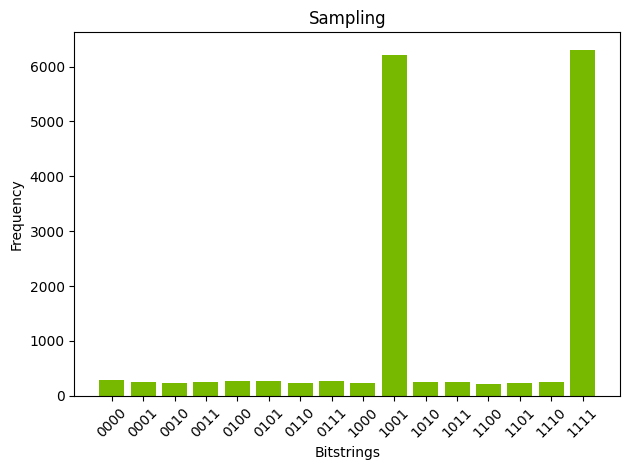

The angle between the resulting state and the good state
 after one iteration of the circuit is  27.88556683609383


In [71]:
# Define the Grover diffusion operator

@cudaq.kernel
def diffusion_operator(qubits: cudaq.qview, num_qubits : int):

    # Apply Hadamard gates
    h(qubits)
    # Apply rotation about the all zero state
    all_zero_reflection(qubits, num_qubits)
    # Apply Hadamard gates
    h(qubits)

num_qubits = 4

# Create a kernel to carry out one iteration of the rotation gate sequence
@cudaq.kernel
def one_iteration(num_qubits: int):
    qubits = cudaq.qvector(num_qubits)
    
    # Initialize qubits in an equal superposition state
    equal_superposition(qubits)

    # Apply the phase oracle once
    phase_oracle(qubits)
    # Apply one iteration of the diffusion operator
    diffusion_operator(qubits, num_qubits)

state = cudaq.get_state(one_iteration, num_qubits)
print('The resulting state is', format_quantum_state(4, state))

# sample
sample_result = cudaq.sample(one_iteration, num_qubits, shots_count = 16000)

# Plot the histogram of sampling results
plot_results(sample_result, num_qubits)

# Compute the angle between the resulting state and |G> from their dot product
dot_product = 0
for key in ['1001','1111']:
    dot_product+=(1/np.sqrt(2))*(abs(state.amplitude(key).real))
angle = np.arccos(dot_product)*180/np.pi
print('The angle between the resulting state and the good state\n after one iteration of the circuit is ',angle)


### Steps 4 and 5: Iteration and measurement

Depending on $n$ and the number of marked states $t$, one iteration of the gate sequence $\mathcal{G}$ may not amplifiy the good states enough to distinguish them from the bad states.  However, iterating this sequence one more time will result in a vector $\frac{\pi}{2}-5\theta$ radians away from the state $\ket{G}$, further amplifying the good states.  We can repeat this until we are close enough to the good state.  But we have to be careful not to repeat this gate sequence too many times as we may overshoot the good state.  In this section we'll derive a formula that will tell us how many times we'll need to iterate the rotation gate sequence in Grover's algorithm.

#### Steps 4 and 5: Explanation
Since the initial angle between $|\xi\rangle$ and $|B\rangle$ is $\theta$, applying $\mathcal{G}$ for $m$ times produces a vector

$$
\mathcal{G}^{m} |\xi\rangle
$$

that forms an angle of $(2m+1)\theta$ with $|B\rangle$.

Since the desired final state $|G\rangle$ is at an angle of $\frac{\pi}{2}$ from $|B\rangle$, we need:

$$
(2m+1)\theta \approx \frac{\pi}{2}.
$$

Recalling that

$$
\theta = \arcsin\left(\sqrt{\frac{t}{N}}\right),
$$

and using the small-angle approximation $\sin(\theta) \approx \theta$ for $\theta \ll 1$, we obtain:

$$
(2m+1) \theta \approx \frac{\pi}{2} \quad \Rightarrow \quad m \approx \left\lfloor \frac{\pi}{4\theta} \right\rfloor = \left\lfloor \frac{\pi}{4} \cdot \sqrt{\frac{N}{t}} \right\rfloor.
$$

Thus, after approximately

$$
m \approx \left\lfloor \frac{\pi}{4} \sqrt{\frac{N}{t}} \right\rfloor
$$

iterations, the state is very close to $|G\rangle$, ensuring that a measurement in the computational basis yields a solution with high probability.



#### Steps 4 and 5: Step\-by\-step example

Edit the `num_iterations` variable in the code block below to compute the angle between the resulting state of `num_iterations` iterations of the Grover diffusion operator and the state $\ket{G}$ along with the histogram of the resulting sampling distribution.  Edit the `num_iterations` variable value in the code block below.  Notice how increasing the number of iterations beyond a certain point produces states with lower probability amplitudes of the marked states than desired.  Why might this happen? What number of iterations results in a better chance of sampling a marked state? How does this compare from the number of iterations that are prescribed by the formula:
$
m \approx \left\lfloor \frac{\pi}{4} \sqrt{\frac{N}{t}} \right\rfloor?
$


The resulting state is 0.25|0000> + 0.25|0001> + 0.25|0010> + 0.25|0011> + 0.25|0100> + 0.25|0101> + 0.25|0110> + 0.25|0111> + 0.25|1000> + 0.25|1001> + 0.25|1010> + 0.25|1011> + 0.25|1100> + 0.25|1101> + 0.25|1110> + 0.25|1111> 


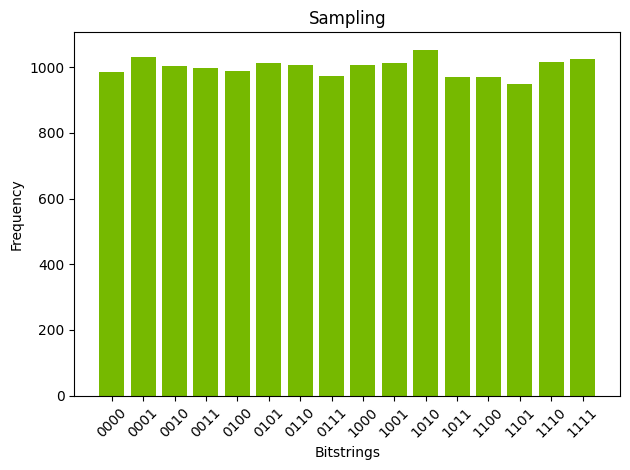

The angle between the resulting state and the good state
 after  0  iteration(s) of the circuit is  69.29518894536459


In [72]:
num_qubits = 4
num_iterations = 0 # CHANGE ME to an integer between 0 and 10

# Apply the Grover diffusion operation to the equal superposition state
@cudaq.kernel
def grovers(num_qubits: int, num_iterations : int):
    qubits = cudaq.qvector(num_qubits)

    # Initialize qubits in an equal superposition state
    equal_superposition(qubits)

    # Apply num_iteration iterations of the diffusion operator
    for _ in range(num_iterations):
        phase_oracle(qubits)
        diffusion_operator(qubits, num_qubits)


state = cudaq.get_state(grovers, num_qubits, num_iterations)
print('The resulting state is', format_quantum_state(num_qubits, state))

# sample
sample_result = cudaq.sample(grovers, num_qubits, num_iterations, shots_count = 16000)

# Plot the histogram of sampling results
plot_results(sample_result, num_qubits)

# Compute the angle between the resulting state and |G> from their dot product
dot_product = 0
for key in ['1001','1111']:
    dot_product+=(1/np.sqrt(2))*(abs(state.amplitude(key).real))
angle = np.arccos(dot_product)*180/np.pi
print('The angle between the resulting state and the good state\n after ',num_iterations,' iteration(s) of the circuit is ',angle)

## Summary

The steps of the algorithm can be summarized as follows.

Step 1. Initialize the uniform superposition state:
    $$
    |\xi\rangle = H^{\otimes n} |0^{\otimes n}\rangle,
    $$
    on the first $n$ qubits and initialize the auxilary qubit in the minus state.

 Steps 2, 3, and 4. Apply the rotation gate sequence exactly $m$ times, where:
    $$
    m \approx \left\lfloor \frac{\pi}{4} \sqrt{\frac{N}{t}} \right\rfloor.
    $$
 Step 5.   Sample the circuit with `shots_count=1`, obtaining a basis state $|j\rangle$. Check whether $j$ is a solution by evaluating $f(j)$. If $f(j) = 1$, return $j$; otherwise, restart the algorithm.

This procedure ensures that with high probability, the measurement yields a correct solution in approximately $\mathcal{O}(\sqrt{N/t})$ steps, providing a quadratic speedup over classical exhaustive search.



One of the applications of Grover's algorithm is solving satisfiability (SAT) problems, which is critical in software verification. SAT, in general, is NP complete.  The exercise below is a toy example of a SAT problem that you can try to solve with Grover's algorithm to test your understanding.

**EXERCISE.** Suppose Lewis wants to throw a party and invites Alice, the cat, and the rabbit. However, due to recent events in Wonderland, the following conditions must be met:

1. Alice joins the party if and only if the cat also joins, and the rabbit does not.
2. The rabbit will only participate if the cat is also present.
3. The cat dislikes the rabbit’s company and will not come if the rabbit is there.

It is easy to verify that the only valid arrangements satisfying these conditions are:

 <ul>
  <li>no one attends the party;</li>
  <li>Alice and the cat attend together.</li>
</ul>

**Solution.** We encode this problem using three bits: a bit value of $1$ indicates attendance, while $0$ indicates absence. Assigning the first bit to Alice, the second to the cat, and the third to the rabbit, we define a Boolean function $f: \mathbb{B}^3 \rightarrow \{0,1\}$ that marks valid solutions:

$$
f(000) = f(110) = 1, \quad f(x) = 0 \text{ otherwise}.
$$

Applying Grover's algorithm, we note that the total number of states is $N = 2^3 = 8$ and the number of solutions is $t = 2$. The superposition of solutions is given by
$$
|G\rangle = \frac{1}{\sqrt{2}}(|000\rangle + |110\rangle),
$$
while the equal superposition of the remaining states is
$$
|B\rangle = \frac{1}{\sqrt{8-2}}(|001\rangle + |010\rangle + |100\rangle + |011\rangle + |101\rangle + |111\rangle).
$$

As we have $N = 2^3 = 8$, the angle $\theta$ satisfies:
$$
\theta = \arcsin\left(\sqrt{\frac{t}{N}}\right) = \arcsin\left(\sqrt{\frac{2}{8}}\right) = \arcsin\left(\frac{1}{2}\right) = \frac{\pi}{6}.
$$
We solve for $m$:
$$
(2m+1)\theta = \frac{\pi}{2} \quad \Rightarrow \quad (2m+1)\frac{\pi}{6} = \frac{\pi}{2} \quad \Rightarrow \quad 2m+1 = 3 \quad \Rightarrow \quad m = 1.
$$
Thus, a single iteration of the Grover diffusion operator maps $|\xi\rangle$ exactly to $|G\rangle$, ensuring that the subsequent measurement yields a valid solution with $100\%$ probability!  

Try writing the code for this.  In particular, you will need to create new code for the phase oracle.